# [Ravi Raghavan]
# Netflix Stock Prices Notebook
---

# Preamble

In [108]:
# import relevant Python libraries
###
import numpy as np  #import numpy 
import pandas as pd #import pandas
from scipy import stats as sps  #import stats from scipy
from matplotlib import pyplot as plt    #import pyplot from matplotlib
from mpl_toolkits.mplot3d import Axes3D #import Axes3D from mpl_toolkits.mplot3d
from IPython.display import display, Latex  #import display and Latex from IPython.display
import seaborn as sns
from sklearn import preprocessing as sklpp
from sklearn import decomposition as skldecomp 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge, Lasso

###

# **1. Brief Exploration of Dataset**

In [109]:
netflix_stock_prices = pd.read_csv("NFLX.csv") #read in netflix stock prices into pandas dataframe 
print(netflix_stock_prices.head(10)) #display first two rows of dataframe just to get a feel for what the dataframe contains 

         Date        Open        High         Low       Close   Adj Close  \
0  2018-02-05  262.000000  267.899994  250.029999  254.259995  254.259995   
1  2018-02-06  247.699997  266.700012  245.000000  265.720001  265.720001   
2  2018-02-07  266.579987  272.450012  264.329987  264.559998  264.559998   
3  2018-02-08  267.079987  267.619995  250.000000  250.100006  250.100006   
4  2018-02-09  253.850006  255.800003  236.110001  249.470001  249.470001   
5  2018-02-12  252.139999  259.149994  249.000000  257.950012  257.950012   
6  2018-02-13  257.290009  261.410004  254.699997  258.269989  258.269989   
7  2018-02-14  260.470001  269.880005  260.329987  266.000000  266.000000   
8  2018-02-15  270.029999  280.500000  267.630005  280.269989  280.269989   
9  2018-02-16  278.730011  281.959991  275.690002  278.519989  278.519989   

     Volume  
0  11896100  
1  12595800  
2   8981500  
3   9306700  
4  16906900  
5   8534900  
6   6855200  
7  10972000  
8  10759700  
9   8312400 

_[The first code cell here is to simply load the netflix stock prices data into a pandas dataframe. Then, I will print the dataframe just to get a feel for what the dataframe contains. ]_

In [110]:
n, p = netflix_stock_prices.shape #get shape of dataframe(n: number of rows, p: number of columns)
print(f"Number of Rows in Dataframe: {n}") #print number of rows
print(f"Number of Columns in dataframe: {p}") #print total number of columns in dataframe

Number of Rows in Dataframe: 1009
Number of Columns in dataframe: 7


_[To briefly explore this dataset, the first thing I wanted to do was first calculate the total number of rows in my dataframe and the total number of columns in my dataframe. There are a total of 1009 rows in this dataframe. This means that the dataframe contains data across 1009 different days that the value of the Netflix Stock was measured. There are 7 rows in this dataframe. The first column is "Date" which indicates the date that data was gathered about the Netflix Stock. The second column is "Open" which represents the price at which stock opened. The third column is "High" which represents the peak price of the Netflix Stock for that particular day. The fourth column is "Low" which represents the low price of the Netflix Stock for that particular day. The fifth column is "Close" which represents the closing price of the Netflix Stock for that particular day. The sixth column is "Adjusted Close" which represents the adjusted closed price adjusted for splits, dividends, and capital gains distributions. Finally, the seventh column is "Volume" which represents the volume of Netflix Stock for that particular day. ]_

In [111]:
valuesMissing = netflix_stock_prices.isna().sum().sum() #Compute total number of Cells with Missing Values
print(f"Number of missing values: {valuesMissing}")

Number of missing values: 0


_[The next step is to calculate the number of cells with missing values(i.e. empty cells). Luckily, our dataset has 0 missing values]_

The column Date can not be represented as a histogram


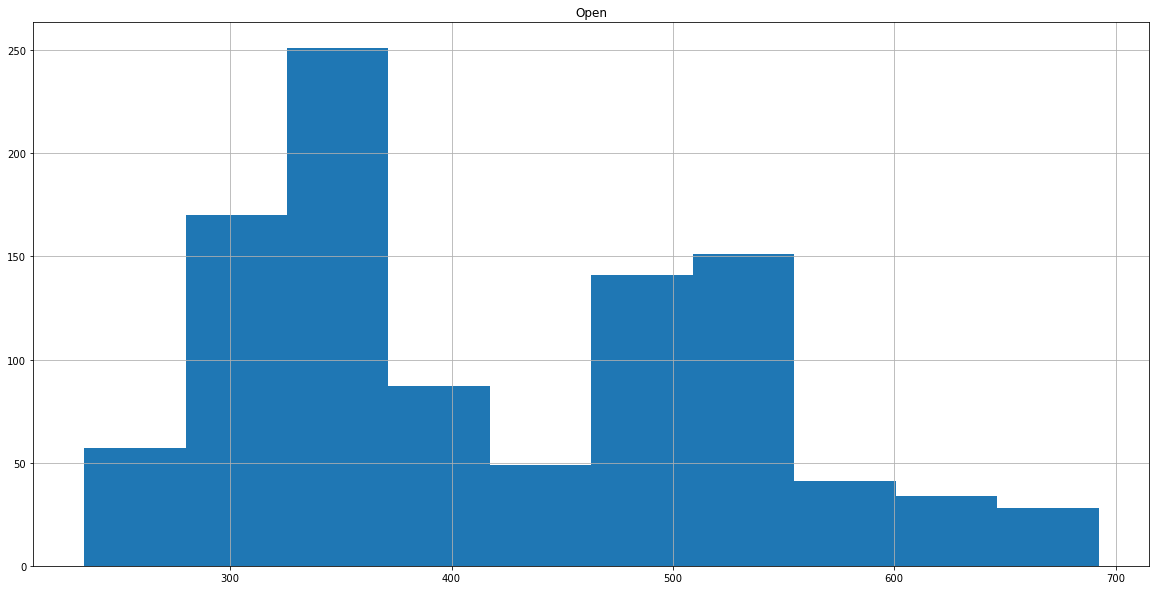

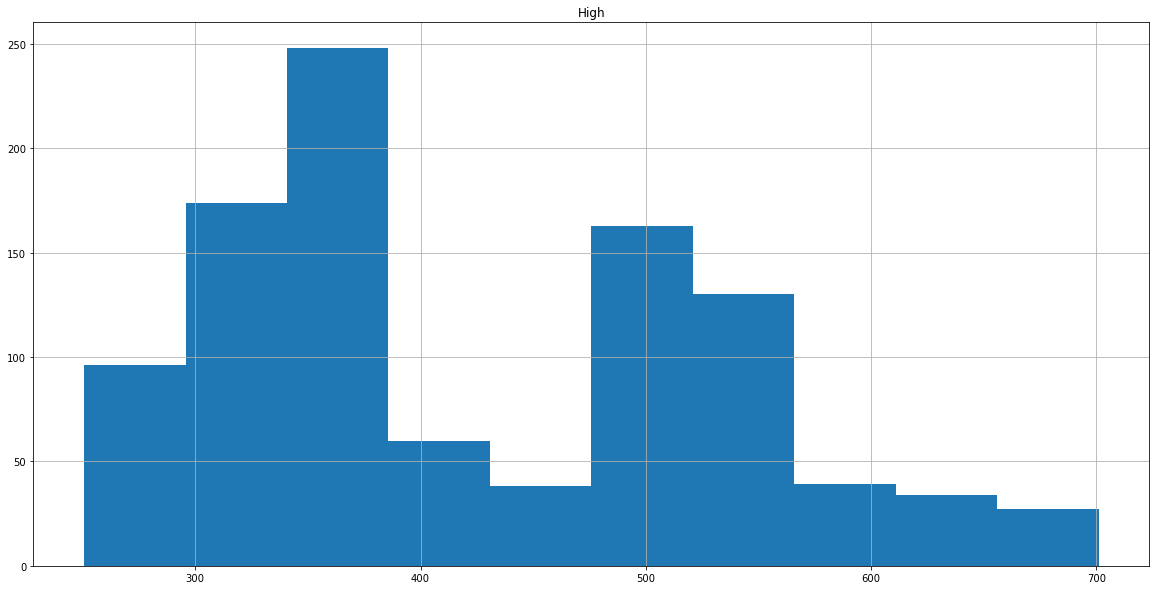

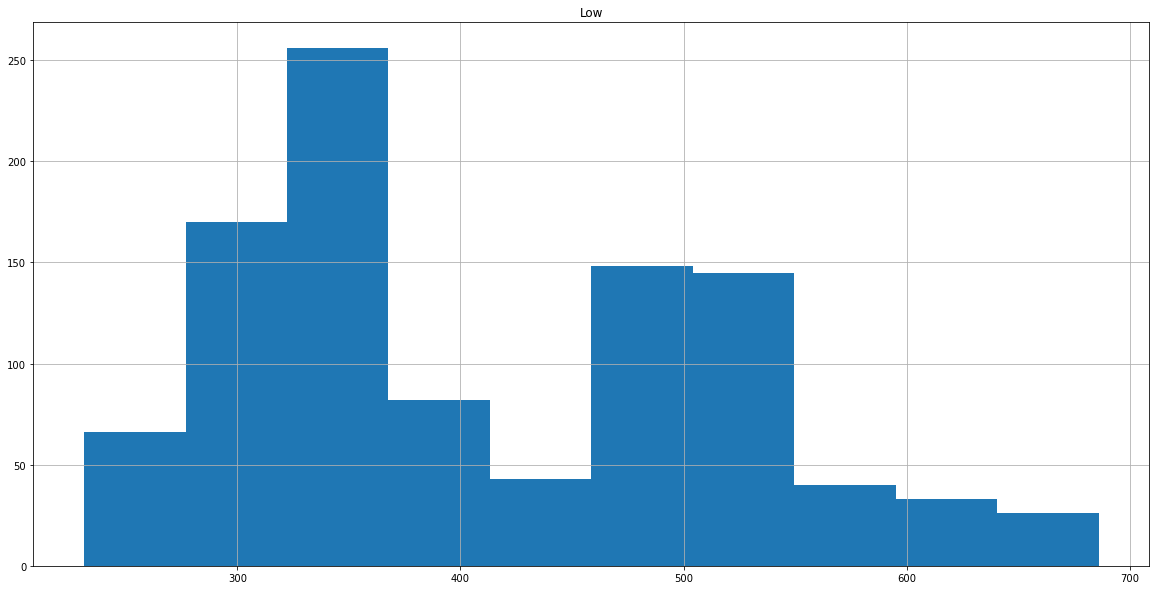

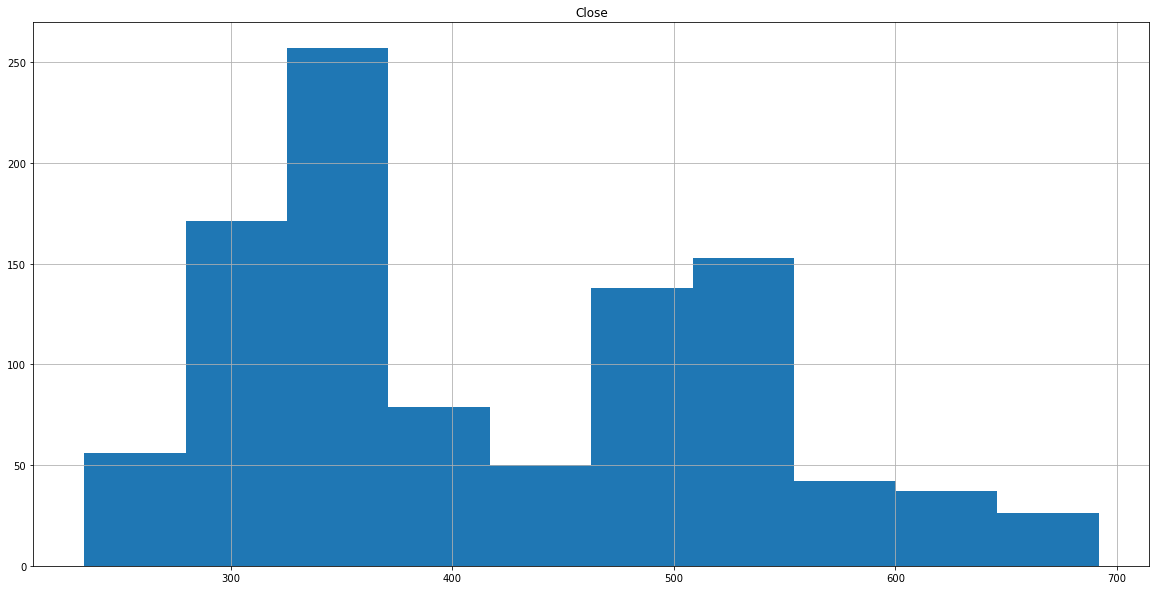

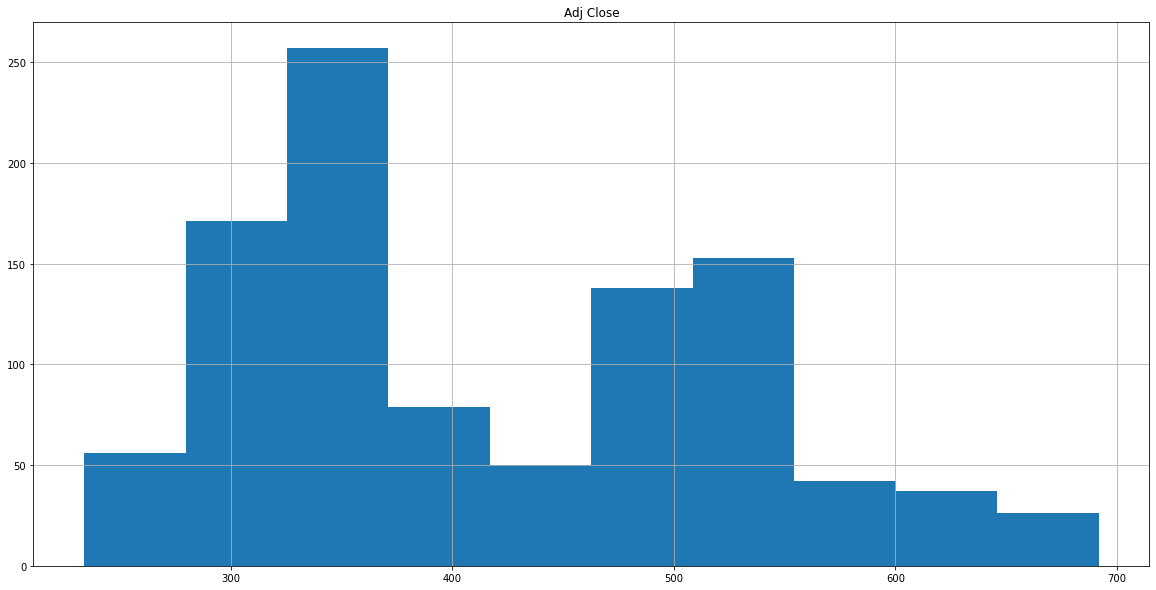

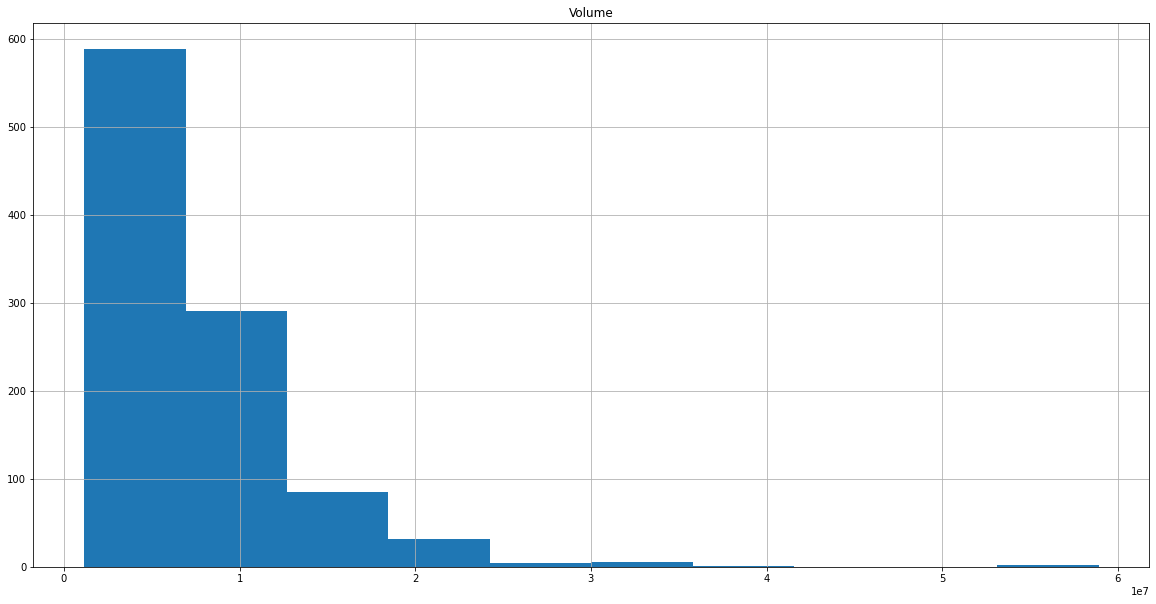

In [112]:
for column in netflix_stock_prices.columns:
    try:      
        netflix_stock_prices[column] = pd.to_numeric(netflix_stock_prices[column]) 
        netflix_stock_prices.hist(column)
    except ValueError:
        print(f"The column {column} can not be represented as a histogram")

_[The second part of this brief data exploration is to figure out which features are categorical. The reason I need to do this is so that I can figure out which features to one-hot encode during the next phase(i.e. when we are preprocessing the data). This part of the analysis clearly shows that the features Open, High, Low, Close, Adj. Close, and Volume are not categorical variables because they don't take on a finite set of values. They can take on an infinite range of values. Hence, by definition, they cannot be considered categorical. The "Date" column is not really considered a variable here for the sake of analysis because its more so used to identify each data sample. Hence, I am not really considering it as a "variable" for analysis. Hence, given the aforementioned statements, it is clear that there are no categorical variables. ]_

Text(0.5, 1.0, 'Netflix Inc.')

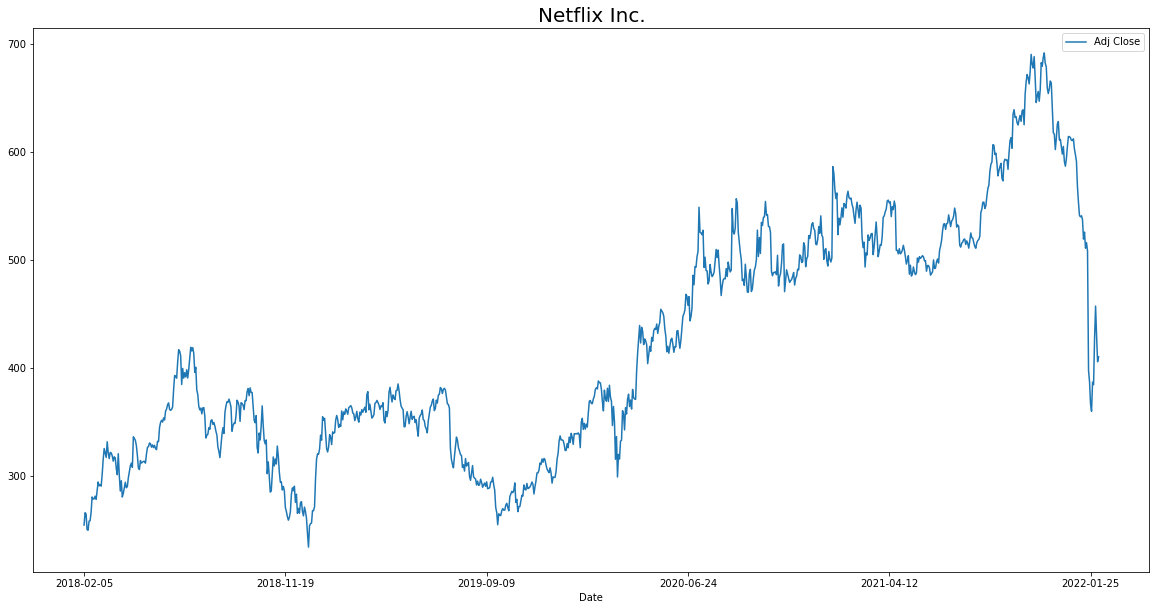

In [113]:
netflix_stock_prices.set_index("Date", inplace = True) #set date as the index
netflix_stock_prices[['Adj Close']].plot(figsize= (20, 10)) #Plot Stock Values for Netflix Over period from Feb 2018 to Feb 2022
plt.title("Netflix Inc.", fontsize = 20) #Title the Plot Netflix Inc. 

_[Since the Date variable is used to identify each data sample, I set the index of this dataframe to be the "Date" variable. I plotted the Adj.Close column of the dataframe on a graph to see the trends in Netflix Stock Price from Feb 2018 to Feb 2022. Clearly, we can see a general upwards trend over the past 5 years but quite few short-term fluctuations in the stock price. Another interesting thing to note is that, around January of 2022, there has been a sharp drop in the stock price of Netflix. This is, most probably, due to the fact that Netlix has been losing approximately 200,000 subscribers in the first three months of 2022 (i.e. first economic quarter)(https://www.theguardian.com/media/2022/apr/20/netflix-shares-fall-losing-subscribers). ]_

# **2. Pre-processing of Dataset**

In [114]:
#given the name of a feature and its corresponding value, return True if the value is logically valid for this feature
def is_logical(feature, value):
    #if value is np.nan or None, return false
    if (value == np.nan or value == None):
        return False
    
    #if feature is not olume, return True if the value >= 125 and value <= 750
    if (feature != "Volume"):
        return value >= 125 and value <= 750
    
    #Else, we know the feature concerns the volume of the stock. Return true if the value >= 1 million and value <= 60 million
    return value >= 1000000 and value <= 60000000 

for column in netflix_stock_prices:
    columnSeries = netflix_stock_prices[column] #retrieve column from data frame
    li = [] #list to store newly created column
    
    #Go through all values in the column. If the value is logically consistent, append this value to the list
    #If the value is not logically consistent, append NaN to the list
    for value in columnSeries:
        if (is_logical(column, value)):
            li.append(value)
        else:
            li.append(np.nan)
    
    #Convert li to pandas Series and store this in the column
    if (np.nan in li):
        netflix_stock_prices[column] = pd.Series(li, index = netflix_stock_prices.index)   

netflix_stock_prices.interpolate(inplace = True) #fill in NaN values via interpolation



_[After looking up the Netflix Stock Prices from Feb 2018 to Feb 2022, the lowest the stock price ever got to was roughly 175 and the highest it ever got to was 700. Hence, to set a reasonable buffer, I made the lower bound for price 125 and the higher bound 750. For volume, the lowest volume for stock prices from Feb 2018 to Feb 2022 was roughly 1.7 million and the highest was around 50 million. Hence, for a reasonable buffer, I set the lower bound for volume to be 1 million and the upper bound to be 60 million. Once I wrote the function to determine whether a value for particular feature is logically valid, I went through the dataframe to validate each and every value. Invalid values were simply repalced with NaN. After I finished validating values, I replaced any NaN values via simple interpolation. Essentially if there were NaN values between non-NaN values, the function interpolate() draws a line between the NaN values and replaces the NaN values with values on this line.  ]_

# **3. Feature Engineering / Feature Learning**

[79.14789140182056, 99.11090488975582, 99.97397004084726, 100.0, 100.0]


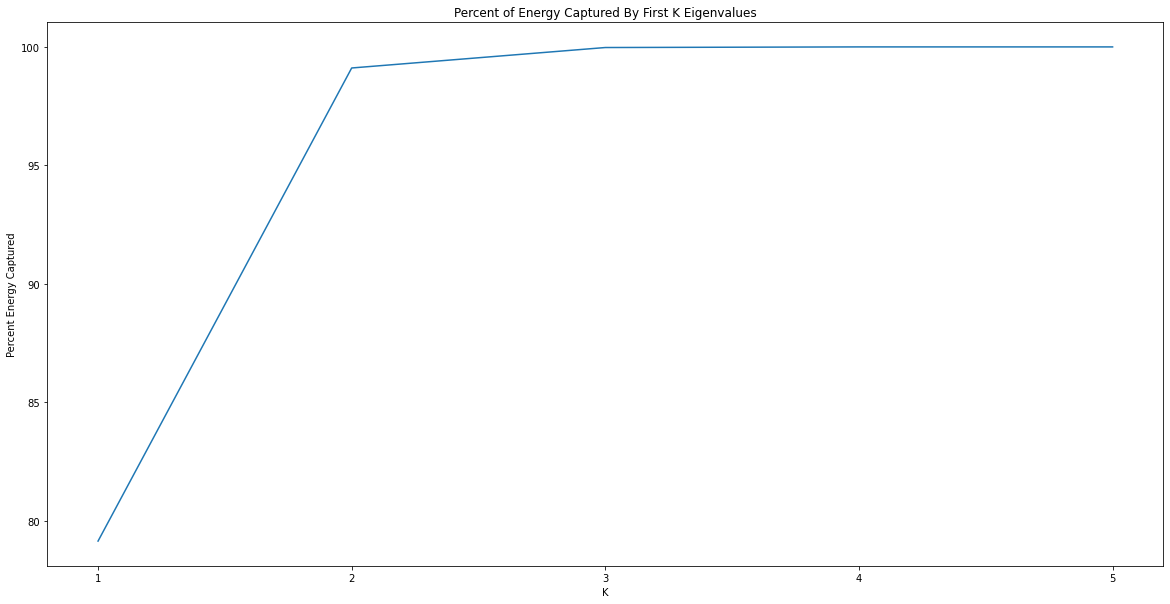

In [115]:
window_size = 14 #window of size 14
closing_prices = netflix_stock_prices["Adj Close"] #get closing prices 
moving_average = closing_prices.rolling(window = window_size, closed = "left").mean() #compute moving average over the past "window_size" days
standard_deviation = closing_prices.rolling(window = window_size, closed = "left").std() #compute standard deviation over the past "window_size" days
upper_band = moving_average + 2 * standard_deviation #compute upper band of bollinger band
lower_band = moving_average - 2 * standard_deviation #compute lower band of bollinger band
rate_of_change = closing_prices.pct_change().shift(1) #compute daily returns(i.e. rate of change)

exponential_moving_average = [np.nan for index in range(window_size)] #initialize array
exponential_moving_average.append(sum(closing_prices[:window_size]) / (window_size)) #calculate SMA of first window
for index in range(window_size + 1, len(closing_prices)):
	closing_price = closing_prices[index - 1]  #closing price
	exponential_moving_average.append((closing_price * (2 / (1 + window_size))) + exponential_moving_average[-1] * (1 - (2 / (1 + window_size)))) #calculate EMA for next window and append it to array

netflix_stock_prices["Moving Average"] = moving_average #moving average
netflix_stock_prices["Upper Bollinger Band"] = upper_band #upper band
netflix_stock_prices["Lower Bollinger Band"] = lower_band #lower band
netflix_stock_prices["Exponential Moving Average"] = exponential_moving_average #Exponential Moving Average
netflix_stock_prices["Rate Of Change"] = rate_of_change #Rate of Change

X = netflix_stock_prices[["Moving Average", "Upper Bollinger Band", "Lower Bollinger Band", "Exponential Moving Average", "Rate Of Change"]].to_numpy() #Create X
X = X[window_size + 2: ] #Choose relevant data samples
Y = netflix_stock_prices[["Adj Close"]].to_numpy() #Create Y
Y = Y[window_size + 2: ] #Choose relevant labels

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=104, test_size=0.20, shuffle=True) #split data into train/test
#X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, random_state = 104, test_size = 0.25, shuffle = True) #split training data into train/validation

# use the fit_transform API to simultaneously compute mean and center data
datascaler = sklpp.StandardScaler() #initialize Standard Scaler object
X_train = datascaler.fit_transform(X_train) #fit it to training data and transform
#X_validation = datascaler.transform(X_validation) #transform validation data
X_test = datascaler.transform(X_test) #transform test data

#solve PCA problem to capture at least roughly 90% energy
left_singular_vectors, singular_value_matrix, right_singular_vectors = np.linalg.svd(X_train)   #svd of centered matrix
total_energy = sum([singular_value * singular_value for singular_value in singular_value_matrix]) #total energy in centered dataset

cumulative_energy = 0   #initialize variable
k_values = [] #initialize array
percent_energy_captured = [] #initialize array
k = 0   #initialize k
for index in range(len(singular_value_matrix)):
    cumulative_energy = cumulative_energy + (singular_value_matrix[index] * singular_value_matrix[index])   #calculate energy of top k singular values
    k = k + 1   #increment k
    k_values.append(k) #append k to array
    percent_energy_captured.append((100 * cumulative_energy / total_energy)) #append percent energy captured cumulatively to the array

print(percent_energy_captured) #print percent_energy_captured

#Plot percent of energy captured by first k eigenvalues
fig, ax = plt.subplots()
ax.set_title("Percent of Energy Captured By First K Eigenvalues")
ax.set_xlabel("K")
ax.set_ylabel("Percent Energy Captured")
ax.plot(k_values, percent_energy_captured)
ax.xaxis.set_major_locator(mticker.IndexLocator( base = 1, offset = 0))    


pca = skldecomp.PCA(n_components = 2, svd_solver = 'full')  #initialize PCA object with 4 components
X_train = pca.inverse_transform(pca.fit_transform(X_train)) #map training data points onto PCA subspace
#X_validation = pca.inverse_transform(pca.transform(X_validation)) #map validation data points onto same PCA subspace
X_test = pca.inverse_transform(pca.transform(X_test)) #map test data points onto same PCA subspace



Analysis of Feature Engineering/Learning: 

Bollinger Bands: 

What are Bollinger Bands? 
Bollinger Bands consists of three bands(i.e. a middle band, an upper band, and a lower band). The middle band is essentially a moving average of the stock price. The upper and lower bands lie above/below the middle band by a certain number of standard deviations. For the purpose of this machine learning mode, I chose the standard deviation to be 2 since this is the standard deviation that is most commonly chosen(https://www.investopedia.com/terms/b/bollingerbands.asp). Bollinger bands are commonly used by stock traders to evaluate a stock’s volatility(https://www.schwab.com/learn/story/bollinger-bands-what-they-are-and-how-to-use-them). Usually, traders compare a stock’s price relative to the Bollinger bands(https://www.schwab.com/learn/story/bollinger-bands-what-they-are-and-how-to-use-them). If the stock price is closer to the upper band, then it can be shown that the stock’s price is relatively high. On the other hand, if the stock’s price is closer to the lower band, then it can be shown that the stock’s price is relatively low. Another piece of information we can glean from the Bollinger Band is that the width of the Bollinger Band(i.e. spread across the lower to upper band) is an indicator of a stock’s volatility(https://www.schwab.com/learn/story/bollinger-bands-what-they-are-and-how-to-use-them). This makes perfect sense. A Bollinger Band that has a larger spread(i.e. larger distance between upper and lower band) indicates a stock price that fluctuates quite a lot. On the other hand, a Bollinger Band that has a smaller spread(i.e. smaller distance between upper and lower band) indicates a stock price that doesn’t fluctuate that much. 

As shown by the above discussion, since Bollinger Bands are a good indication of a stock’s volatility, I included the Moving Average, Upper Band, and Lower Band(i.e. the three components of a Bollinger Band) as features for my Machine Learning Model 

Exponential Moving Average: 

What is the Exponential Moving Average? 
This term sounds quite similar to Moving Average(i.e. the middle band of the Bollinger Band). However, there is an important distinction that we should discuss. Moving Average(i.e. often referred to as Simple Moving Average) simply takes the average of the stock price over a certain period. Exponential Moving Average(EMA) is very similar in that it strives to capture the trend direction of the stock over a period of time(https://www.fidelity.com/learning-center/trading-investing/technical-analysis/technical-indicator-guide/ema). However,  the key distinction is that EMA computes a weighted average and, in the process, assigns higher weights to stock prices that occur more recently. This way, EMA is more sensitive to price movement and tend to identify trends in stock prices earlier than regular Moving Averages do. 

As shown by the above discussion, since Exponential Moving Averages are more sensitive to price movements and can identify stock price trends earlier than regular Moving Averages,  I felt that EMA(Exponential Moving Average) is a good indicator of trend direction. Hence, I chose to include Exponential Moving Averages as one of my features in the Machine Learning model. 

Rate of Change: 

What is the Rate of Change?
Rate of Change is the daily gain/loss posted by a stock. According to Investopedia(https://www.investopedia.com/terms/r/rateofchange.asp#:~:text=The%20Importance%20of%20Measuring%20Rate,market%20in%20the%20short%20term.), securities with “high momentum, or one that has a positive ROC, normally outperforms the market in the short term. Conversely, a security that has a ROC that falls below its moving average, or one that has a low or negative ROC is likely to decline in value and can be seen as a sell signal to investors”

 

Why was PCA used on the data matrix? 
In order to determine whether PCA was needed on my data matrix, I calculated the SVD of my data matrix X. As we learned during our studies of PCA, the singular values of X are the square root of the eigenvalues of X^T X. Hence, we can analyze the singular values of X to determine what percentage of the total energy is captured by the top K eigenvalues of X^TX. As shown by graph, the top 2 eigenvalues capture roughly 99 percent of the total energy in the dataset. Hence, we can take the data from the original 5 dimensional space and map it to a 2 dimensional subspace within this 5 dimensional space. Since we will be capturing roughly 99 percent of the total energy in the dataset, the projected data samples will still retain the original variation from the dataset that was present in 5 dimensions. Hence, this is why I conducted PCA with the number of components being 2 





# **4. Processing The Dataset Via Machine Learning**

In [116]:
plt.figure(figsize=(15, 10))

alphas = np.linspace(0, 1500, 100, endpoint = False)

cross_validation_scores_model1 = [cross_val_score(Ridge(alpha), X_train, Y_train) for alpha in alphas]
mean_scores_model1 = [scores.mean() for scores in cross_validation_scores_model1]
std_scores_model1 = [scores.std() for scores in cross_validation_scores_model1]
best_alpha_model1 = alphas[np.argmax(mean_scores_model1)]

print(f"Best Value of Alpha for Ridge Regression: {best_alpha_model1}")

alphas = np.linspace(1, 101, 100, endpoint = False)
cross_validation_scores_model2 = [cross_val_score(Lasso(alpha), X_train, Y_train) for alpha in alphas]
mean_scores_model2 = [scores.mean() for scores in cross_validation_scores_model2]
std_scores_model2 = [scores.std() for scores in cross_validation_scores_model2]
best_alpha_model2 = alphas[np.argmax(mean_scores_model2)]

print(f"Best Value of Alpha for Lasso Regression: {best_alpha_model2}")

Best Value of Alpha for Ridge Regression: 15.0
Best Value of Alpha for Lasso Regression: 1.0


<Figure size 1080x720 with 0 Axes>

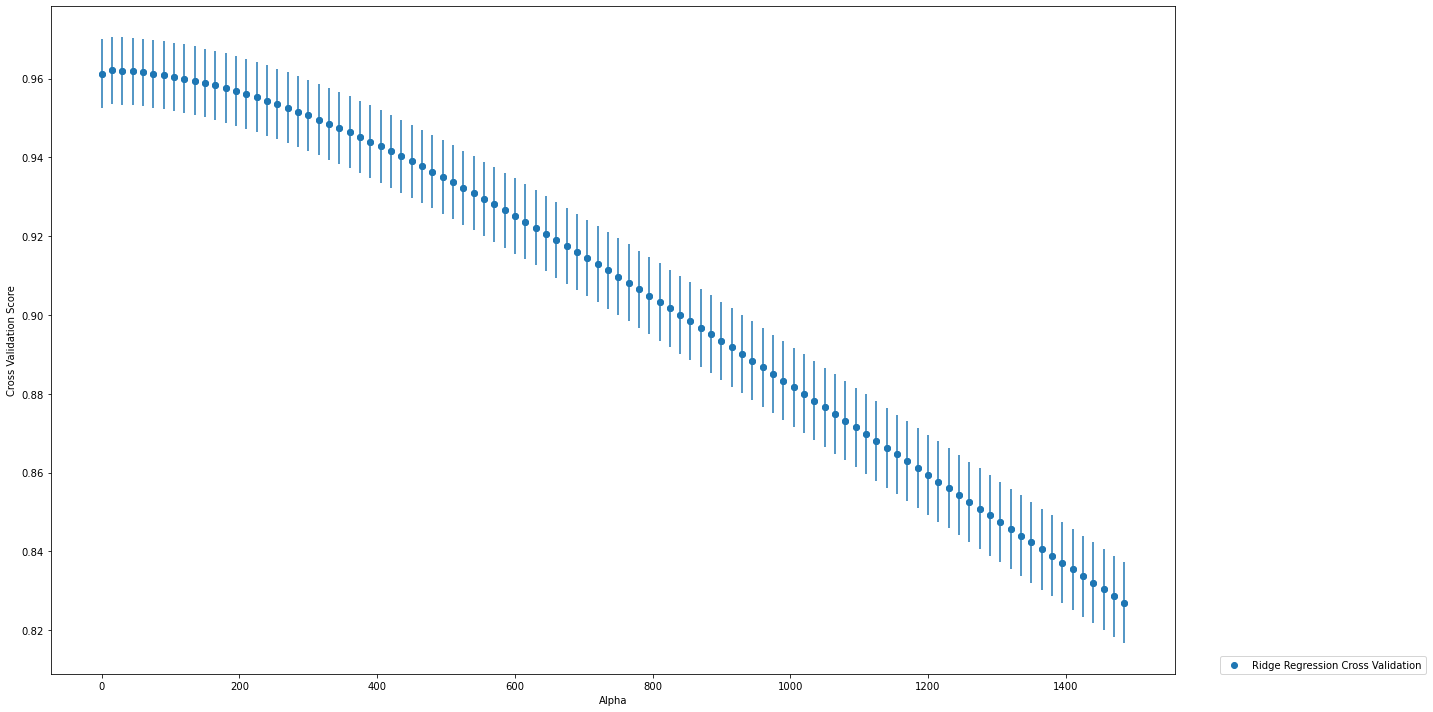

In [117]:
alphas = np.linspace(0, 1500, 100, endpoint = False)
plt.scatter(alphas, mean_scores_model1, label= "Ridge Regression Cross Validation")
plt.errorbar(alphas, mean_scores_model1, std_scores_model1, fmt = "o")
plt.legend(loc = (1.04, 0))
plt.xlabel('Alpha')
plt.ylabel('Cross Validation Score')
plt.tight_layout()
plt.show()
model1 = Ridge(best_alpha_model1).fit(X_train, Y_train) #fit a Linear Regression(i.e. Ridge Regression) model to the data


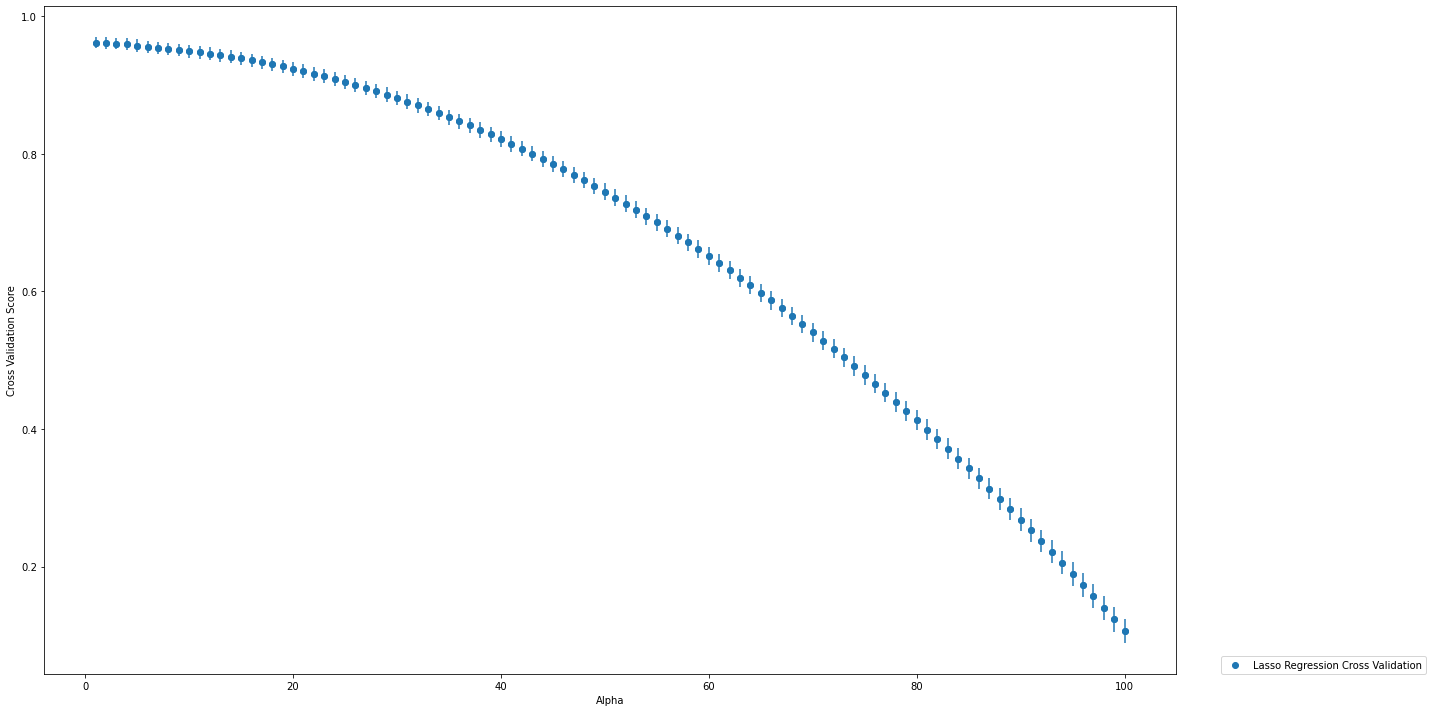

In [118]:
alphas = np.linspace(1, 101, 100, endpoint = False)
plt.scatter(alphas, mean_scores_model2, label= "Lasso Regression Cross Validation")
plt.errorbar(alphas, mean_scores_model2, std_scores_model2, fmt = "o")
plt.legend(loc = (1.04, 0))
plt.xlabel('Alpha')
plt.ylabel('Cross Validation Score')
plt.tight_layout()
plt.show()
model2 = Lasso(best_alpha_model2).fit(X_train, Y_train) #fit a Linear Regression(i.e. Lasso Regression) model to the data

# **5. Comparative Analysis**

In [119]:
future_stock_prices = pd.read_csv("NFLX_Future.csv") #get CSV file with future NFLX prices. This allows me to assess my model's performance
future_stock_prices.set_index("Date", inplace = True) #set index to be the "Date" column
future_stock_prices = future_stock_prices.loc[netflix_stock_prices.index[-1]: ] #pick stock prices for the future(i.e. date where the other csv ends)

N, P = X_test.shape #calculate number of rowx in test dataset
prediction = model1.predict(X_test) #make prediction for test data
error = sum([((actual_label - predicted_label) / actual_label) ** 2 for predicted_label, actual_label in zip(prediction, Y_test)]) / N #calculate test error
print(f"Error on Test Data: {error}") #print test error

num_rows = len(future_stock_prices) #number of future predictions we want to make
exponential_moving_average = exponential_moving_average[(-1 * window_size): ] #keep window of exponential moving averages
closing_prices = closing_prices.to_list() #store closing prices in array
closing_prices = closing_prices[(-1 * window_size): ] #keep window of closing prices
feature_array = np.zeros((1, 5)) #initialize feature array
forecasts = np.zeros((num_rows + 1, 1)) #initialize array of forecasts
forecasts[0] = np.array([closing_prices[-1]]) #keep initial value of forecast as final stock closing price in netflix stock price dataframe

#Iterate through num_rows
for day in range(num_rows):
    avg_price = np.mean(closing_prices) #calculate average price of closing prices(moving average)
    std_price = np.std(closing_prices) #calculate standard deviation of price of closing prices(standard dev)
    ema =  2 * (closing_prices[-1] - exponential_moving_average[-1]) + exponential_moving_average[-1] #calculate Exponential Moving Average
    feature_array[0][0] = avg_price
    feature_array[0][1] = avg_price + 2 * std_price
    feature_array[0][2] = avg_price - 2 * std_price
    feature_array[0][3] = ema
    feature_array[0][4] = (closing_prices[-1] - closing_prices[-2]) / (closing_prices[-2])
        
    feature_array = datascaler.transform(feature_array)
    feature_array = pca.inverse_transform(pca.transform(feature_array))
    forecasted_price = model1.predict(feature_array)
    forecasted_price = forecasted_price[0][0]
    forecasts[day + 1][0] = forecasted_price
    exponential_moving_average = exponential_moving_average[1: ]
    exponential_moving_average.append(ema)
    closing_prices = closing_prices[1: ]
    closing_prices.append(forecasted_price)
    

adjusted_closing_prices = netflix_stock_prices[['Adj Close']].tail(500)
future_stock_predictions_model1 = pd.DataFrame({"Forecasts": forecasts.flatten()}, index=pd.date_range(start= netflix_stock_prices.index[-1], periods=len(forecasts), freq="B", inclusive = "both").format(formatter=lambda x: x.strftime('%Y-%m-%d')))


Error on Test Data: [0.00276981]


In [120]:
N, P = X_test.shape #calculate number of rowx in test dataset
prediction = model2.predict(X_test) #make prediction for test data
error = sum([((actual_label - predicted_label) / actual_label) ** 2 for predicted_label, actual_label in zip(prediction, Y_test)]) / N #calculate test error
print(f"Error on Test Data: {error}") #print test error

num_rows = len(future_stock_prices) #number of future predictions we want to make
exponential_moving_average = netflix_stock_prices["Exponential Moving Average"] #get exponential moving averages
exponential_moving_average = exponential_moving_average.to_list() #convert to list
exponential_moving_average = exponential_moving_average[(-1 * window_size): ] #keep window of exponential moving averages
closing_prices = netflix_stock_prices["Adj Close"] #get closing prices 
closing_prices = closing_prices.to_list() #store closing prices in array
closing_prices = closing_prices[(-1 * window_size): ] #keep window of closing prices
feature_array = np.zeros((1, 5)) #initialize feature array
forecasts = np.zeros((num_rows + 1, 1)) #initialize array of forecasts
forecasts[0] = np.array([closing_prices[-1]]) #keep initial value of forecast as final stock closing price in netflix stock price dataframe

#Iterate through num_rows
for day in range(num_rows):
    avg_price = np.mean(closing_prices) #calculate average price of closing prices(moving average)
    std_price = np.std(closing_prices) #calculate standard deviation of price of closing prices(standard dev)
    ema =  2 * (closing_prices[-1] - exponential_moving_average[-1]) + exponential_moving_average[-1] #calculate Exponential Moving Average
    feature_array[0][0] = avg_price
    feature_array[0][1] = avg_price + 2 * std_price
    feature_array[0][2] = avg_price - 2 * std_price
    feature_array[0][3] = ema
    feature_array[0][4] = (closing_prices[-1] - closing_prices[-2]) / (closing_prices[-2])
        
    feature_array = datascaler.transform(feature_array)
    feature_array = pca.inverse_transform(pca.transform(feature_array))
    forecasted_price = model2.predict(feature_array)
    forecasted_price = forecasted_price[0]
    forecasts[day + 1][0] = forecasted_price
    exponential_moving_average = exponential_moving_average[1: ]
    exponential_moving_average.append(ema)
    closing_prices = closing_prices[1: ]
    closing_prices.append(forecasted_price)
    

adjusted_closing_prices = netflix_stock_prices[['Adj Close']].tail(500)
future_stock_predictions_model2 = pd.DataFrame({"Forecasts": forecasts.flatten()}, index=pd.date_range(start= netflix_stock_prices.index[-1], periods=len(forecasts), freq="B", inclusive = "both").format(formatter=lambda x: x.strftime('%Y-%m-%d')))


Error on Test Data: [0.00286023]


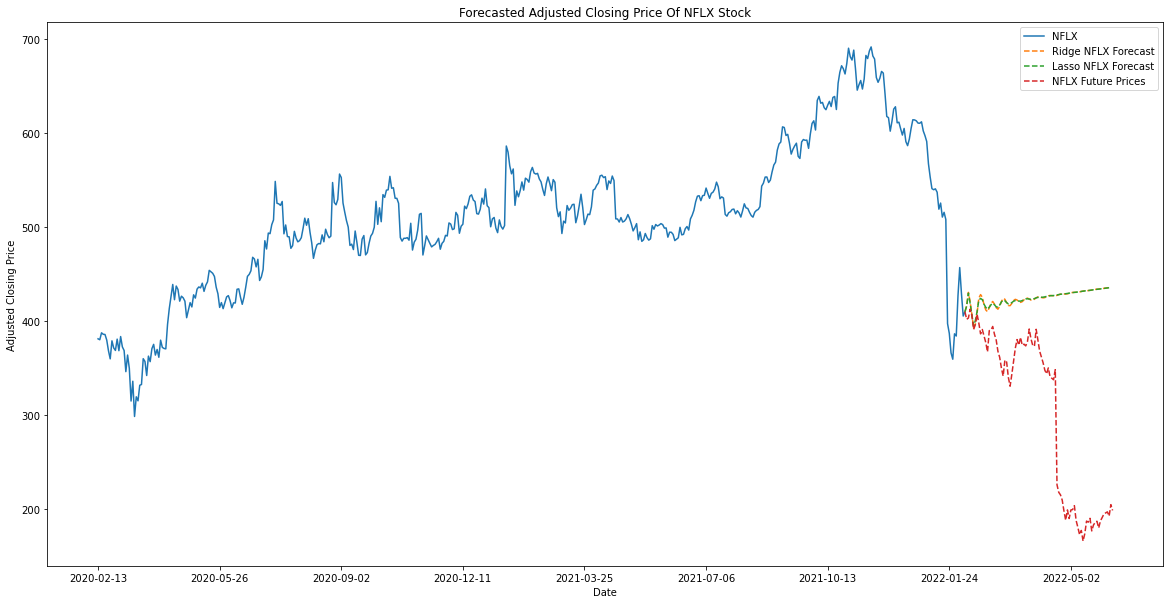

In [121]:
plt.rcParams["figure.figsize"] = (20,10)
fig, ax = plt.subplots()
ax.set_title("Forecasted Adjusted Closing Price Of NFLX Stock")
ax.set_xlabel("Date")
ax.set_ylabel("Adjusted Closing Price")

ax.plot(adjusted_closing_prices['Adj Close'], label = "NFLX")
ax.plot(future_stock_predictions_model1["Forecasts"], linestyle='dashed', label = "Ridge NFLX Forecast")
ax.plot(future_stock_predictions_model2["Forecasts"], linestyle='dashed', label = "Lasso NFLX Forecast")
ax.plot(future_stock_prices['Adj Close'], linestyle='dashed', label = "NFLX Future Prices")
ax.xaxis.set_major_locator(mticker.IndexLocator( base = 70, offset = 0))
ax.legend()

plt.show()


# **6. Discussion of Ethical Issues**

_[In recent years, the predictive capabilities of Machine Learning models have transformed the financial industry. In an attempt to make more prudent investment decisions, Many quantitative trading firms have begun adopting ML models to make stock price forecasts. However, it is essential that the ethical component of using ML-based system in stock forecasting is carefully evaluated, especially due to the rise of stock fraud, Ponzi Schemes, Insider Trading, etc in recent years. 

To begin the disussion on ethical aspects of Machine Learning Stock Prediction Systems, I will provide an outline of the general goal of investing/quantiative trading and speak more closely on the ethical aspects pertaining to each goal. 

The first major goal of investing/quantiative trading is Reasoning/Transparency. Especially in today's world, it is a well known fact that ML, stock forecasting systems are some of the most accurate systems when it comes to stock prediction. However, these models never provide investors with a rational basis for why a particular investment outranks its alternatives. In fact, "the most commonly used Neural Network for prediction is notoriously known as 'black box'"(https://iopscience.iop.org/article/10.1149/10701.0137ecst/pdf). When making investment decisions for their portfolios, investors will, most likely, feel hestitant to simply rely upon a Neural Network to make their investment decisions for them in a black box fashion. Any prudent investor, given that they are investing their own hard-earned money, will want to thoroughly understand the basis behind an investment decisions. Most Neural Networks used for stock predictions rarely give investors that insight. These Neural Networks almost never tell investors how it is making the prediction about a particular stock's value. We are not given information into what factors are being taken into account. Hence, it is understandable why investors won't be too confident in ceding their decision-making capabilities to a black-box model where we don't have an understanding of what this model is actually doing. How does ethics play into this? Well, ML engineers must remember that these Neural Networks are being used to invest real people's money. Failure to provide information into how investment decisions are being made behind the hood leaves investors completely in the dark about how their money is being invested in the market. Subsequently, this may lead to large economic loss for investors as they are largely uncertain how to make rational investment decisions, in absence of the information regarding the formulations used by the Neural Network in making its predictions. Hence, when investors blindly trust the ML models, and the stock market fluctuates wildly(i.e. as it always does), these investors will stand to lose a significant portion of their fortune. This will have large ramifications.  

The second major goal in investing/quantiative trading is Bias. Analysis, when making investment decisions, avoid bias in making investment decisions, rather basing investment decisions upon a holistic review of numerous factors. The same practice must be followed. When Machine Learning models recieve heavily biased input data, they will produce poor predictions. In the financial industry, this means that the input data to Stock Prediction Machine Learning Models should not solely be confined to financial statements of a particular firm(i.e. biased data!). How does ethics play into this? Well, let's consider the scenario where the input data to our Machine Learning Model is heavily biased. Let's say we want to predict the stock price of Apple(i.e. ticker symbol of AAPL) and the data receive is only financial statements of Apple. This data could be heavily biased as the firm itself have it in their best interests to see a rise in their own stock price. Hence, our model could end up predicting a stock price that is very high for Apple, lull most investors into a false sense of promise by incentivizing them to invest in Apple, and, when the market fluctuates, these investors will end up losing quite a lot of money. Hence, avoiding bias in stock prediction machine learning models is essential to avoid the scenario of outlandish model predictions and investors subsequently losing money due to over-optimism

The third major goal in investing/quantitative trading is Accountability. By far, the most important thing when it comes to quantiative trading is that the money invested is the hard-earned money of an investor(i.e. in most cases, an average person). Most Stock Prediction Machine Learning systems don't heed to the importance of accountability for capital invested. Some ML Systems, after observing strong results on a given training data set, are simply put into the production based on the confidence of the engineers who built the system. ML Engineers must view these ML systems, in production, as not just running on "test data" but affecting actual investors. Due to the fact that these ML systems are put into production to help investors make prudent investment decisions, it is important that ML Engineers take into account the effects these models' predictions can have on investors' capital. This is essentially how ethics plays a role. It is simply unethical for an ML Engineer to deploy an ML system based on their own confidence/pride in the system's accuracy rather than a holistic assessment of how the ML System will guide investors to make rational investment decisions for their capital. ]_

# **7. Bibliography**

1. https://iopscience.iop.org/article/10.1149/10701.0137ecst/pdf
2. https://www.theguardian.com/media/2022/apr/20/netflix-shares-fall-losing-subscribers


